# Reproducing Toy Experiment from 5.1
This notebook aims at reproducing the toy experiment from paragraph 5.1.

<br>

Authors of this notebook:
* Louis Allain
* Léonard Gousset
* Julien Heurtin

# Packages needed
All packages needed are imported in this section

In [1]:
from dataclasses import dataclass
from dataclasses import replace

from functools import partial

import jax
import jax.numpy as jnp
from flax import struct
import optax as ox
#import gpjax as gpx # could not build wheel for dm-tree

from ott.geometry.pointcloud import PointCloud
from ott.problems.linear.linear_problem import LinearProblem
from ott.solvers.linear.sinkhorn import Sinkhorn

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

import numpy as np
import matplotlib.pyplot as plt
import time

import pandas as pd
import seaborn as sns

# Set the seed for reproducibility
np.random.seed(42)


/var/folders/nx/gcjsd2hn49l_4ypjlnw3m0d00000gn/T/ipykernel_5433/1016652786.py:25: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Functions from the paper

The following functions are taken from the file ```mu_sinkhorn.py``` from [this GitHub repo.](https://github.com/Algue-Rythme/DistributionRegressionUS2016/tree/main)

In [2]:
def gp_gaussian_posterior(dataset):
  """Returns a GP posterior with a Gaussian likelihood.
  
  Args:
    dataset: a gpx.Dataset.
  """
  kernel = gpx.kernels.RBF()
  meanf = gpx.mean_functions.Zero()
  prior = gpx.Prior(mean_function=meanf, kernel=kernel)
  likelihood = gpx.Gaussian(num_datapoints=dataset.n)
  posterior = prior * likelihood
  negative_mll = gpx.objectives.ConjugateMLL(negative=True)
  return posterior, negative_mll


def gp_map_posterior(dataset):
  """Returns a GP posterior with a Bernoulli likelihood.
  
  Args:
    dataset: a gpx.Dataset.
  """
  kernel = gpx.RBF()
  meanf = gpx.Constant()
  prior = gpx.Prior(mean_function=meanf, kernel=kernel)
  likelihood = gpx.Bernoulli(num_datapoints=dataset.n)
  posterior = prior * likelihood
  negative_lpd = gpx.LogPosteriorDensity(negative=True)
  return posterior, negative_lpd


def fit_posterior(task, x_train, y_train, key):
  """Fits a GP posterior.

  Args:
    task: 'classification' or 'regression'.
    sinkhorn_dual: Array of shape (n, m) where n is the number of points in the
                    dataset and m the number of points in mu.
    labels: Array of shape (n,) where n is the number of points in the dataset.
    key: jax.random.PRNGKey.
  
  Returns:
    A GP posterior.
  """
  dataset = gpx.Dataset(X=x_train, y=y_train)

  if task == 'classification':
    posterior, objective = gp_map_posterior(dataset)
  elif task == 'regression':
    posterior, objective = gp_gaussian_posterior(dataset)

  objective = jax.jit(objective)
  optimiser = ox.adamw(learning_rate=0.01)
  opt_posterior, history = gpx.fit(
      model=posterior,
      objective=objective,
      train_data=dataset,
      optim=optimiser,
      num_iters=1000,
      key=key,
  )

  return opt_posterior, history


@struct.dataclass
class WeightedPointCloud:
  """A weighted point cloud.
  
  Attributes:
    cloud: Array of shape (n, d) where n is the number of points and d the dimension.
    weights: Array of shape (n,) where n is the number of points.
  """
  cloud: jnp.array
  weights: jnp.array

  def __len__(self):
    return self.cloud.shape[0]


@struct.dataclass
class VectorizedWeightedPointCloud:
  """Vectorized version of WeightedPointCloud.

  Assume that b clouds are all of size n and dimension d.
  
  Attributes:
    _private_cloud: Array of shape (b, n, d) where n is the number of points and d the dimension.
    _private_weights: Array of shape (b, n) where n is the number of points.
  
  Methods:
    unpack: returns the cloud and weights.
  """
  _private_cloud: jnp.array
  _private_weights: jnp.array

  def __getitem__(self, idx):
    return WeightedPointCloud(self._private_cloud[idx], self._private_cloud[idx])
  
  def __len__(self):
    return self._private_cloud.shape[0]
  
  def __iter__(self):
    for i in range(len(self)):
      yield self[i]

  def unpack(self):
    return self._private_cloud, self._private_weights


def pad_point_cloud(point_cloud, max_cloud_size, fail_on_too_big=True):
  """Pad a single point cloud with zeros to have the same size.
  
  Args:
    point_cloud: a weighted point cloud.
    max_cloud_size: the size of the biggest point cloud.
    fail_on_too_big: if True, raise an error if the cloud is too big for padding.
  
  Returns:
    a WeightedPointCloud with padded cloud and weights.
  """
  cloud, weights = point_cloud.cloud, point_cloud.weights
  delta = max_cloud_size - cloud.shape[0]
  if delta <= 0:
    if fail_on_too_big:
      assert False, 'Cloud is too big for padding.'
    return point_cloud

  ratio = 1e-3  # less than 0.1% of the total mass.
  smallest_weight = jnp.min(weights) / delta * ratio
  small_weights = jnp.ones(delta) * smallest_weight

  weights = weights * (1 - ratio)  # keep 99.9% of the mass.
  weights = jnp.concatenate([weights, small_weights], axis=0)

  cloud = jnp.pad(cloud, pad_width=((0, delta), (0,0)), mode='mean')

  point_cloud = WeightedPointCloud(cloud, weights)

  return point_cloud


def pad_point_clouds(cloud_list):
  """Pad the point clouds with zeros to have the same size.

  Note: this function should be used outside of jax.jit because the computation graph
        is huge. O(len(cloud_list)) nodes are generated.

  Args:
    cloud_list: a list of WeightedPointCloud.
  
  Returns:
    a VectrorizedWeightedPointCloud with padded clouds and weights.
  """
  # sentinel for unified processing of all clouds, including biggest one.
  max_cloud_size = max([len(cloud) for cloud in cloud_list]) + 1
  sentinel_padder = partial(pad_point_cloud, max_cloud_size=max_cloud_size)

  cloud_list = list(map(sentinel_padder, cloud_list))
  coordinates = jnp.stack([cloud.cloud for cloud in cloud_list])
  weights = jnp.stack([cloud.weights for cloud in cloud_list])
  return VectorizedWeightedPointCloud(coordinates, weights)


def clouds_barycenter(points):
  """Compute the barycenter of a set of clouds.
  
  Args:
    points: a VectorizedWeightedPointCloud.
    
  Returns:
    a barycenter of the clouds of points, of shape (1, d) where d is the dimension.
  """
  clouds, weights = points.unpack()
  barycenter = jnp.sum(clouds * weights[:,:,jnp.newaxis], axis=1)
  barycenter = jnp.mean(barycenter, axis=0, keepdims=True)
  return barycenter


def to_simplex(mu):
  """Project weights to the simplex.
  
  Args: 
    mu: a WeightedPointCloud.
    
  Returns:
    a WeightedPointCloud with weights projected to the simplex."""
  if mu.weights is None:
    mu_weights = None
  else:
    mu_weights = jax.nn.softmax(mu.weights)
  return replace(mu, weights=mu_weights)


def reparametrize_mu(mu, cloud_barycenter, scale):
  """Re-parametrize mu to be invariant by translation and scaling.

  Args:
    mu: a WeightedPointCloud.
    cloud_barycenter: Array of shape (1, d) where d is the dimension.
    scale: float, scaling parameter for the re-parametrization of mu.
  
  Returns:
    a WeightedPointCloud with re-parametrized weights and cloud.
  """
  # invariance by translation : recenter mu around its mean
  mu_cloud = mu.cloud - jnp.mean(mu.cloud, axis=0, keepdims=True)  # center.
  mu_cloud = scale * jnp.tanh(mu_cloud)  # re-parametrization of the domain.
  mu_cloud = mu_cloud + cloud_barycenter  # re-center toward barycenter of all clouds.
  return replace(mu, cloud=mu_cloud)


def embed_single_cloud(weighted_cloud, mu,
                       sinkhorn_solver_kwargs,
                       has_aux=False):
  """Compute the embedding of a single cloud with regularized OT towards mu.

  Args:
    weighted_cloud: a WeightedPointCloud.
    mu: a WeightedPointCloud.
    has_aux: bool, whether to return the whole output vector.
    sinkhorn_solver_kwargs: kwargs for the Sinkhorn solver.

  Returns:
    a vector of shape (n,) where n is the number of points in Mu.
  """
  sinkhorn_solver_kwargs = dict(**sinkhorn_solver_kwargs)  # copy to avoid modifying the function argument.
  sinkhorn_epsilon = sinkhorn_solver_kwargs.pop('epsilon')

  geom = PointCloud(weighted_cloud.cloud, mu.cloud,
                    epsilon=sinkhorn_epsilon)
  
  ot_prob = LinearProblem(geom,
                          weighted_cloud.weights,
                          mu.weights)
  
  solver = Sinkhorn(**sinkhorn_solver_kwargs)

  outs = solver(ot_prob)

  if has_aux:
    return outs.g, outs
  return outs.g


def clouds_to_dual_sinkhorn(points, mu, 
                            init_dual=(None, None),
                            scale=1.,
                            has_aux=False,
                            sinkhorn_solver_kwargs=None):
  """Compute the embeddings of the clouds with regularized OT towards mu.
  
  Args:
    points: a VectorizedWeightedPointCloud.
    init_dual: tuple of two arrays of shape (b, n) and (b, m) where b is the number of clouds,
               n is the number of points in each cloud, and m the number of points in mu.
    scale: float, scaling parameter for the re-parametrization of mu.
    has_aux: bool, whether to return the full Sinkhorn output or only the dual variables.
    sinkhorn_solver_kwargs: dict, kwargs for the Sinkhorn solver.
      Must contain the key 'epsilon' for the regularization parameter.

  Returns:
    a tuple (dual, init_dual) with dual variables of shape (n, m) where n is the number of points
    and m the number of points in mu, and init_dual a tuple (init_dual_cloud, init_dual_mu) 
  """
  sinkhorn_epsilon = sinkhorn_solver_kwargs.pop('epsilon')
  
  # weight projection
  barycenter = clouds_barycenter(points)
  mu = to_simplex(mu)

  # cloud projection
  mu = reparametrize_mu(mu, barycenter, scale)

  def sinkhorn_single_cloud(cloud, weights, init_dual):
    geom = PointCloud(cloud, mu.cloud,
                      epsilon=sinkhorn_epsilon)
    ot_prob = LinearProblem(geom,
                            weights,
                            mu.weights)
    solver = Sinkhorn(**sinkhorn_solver_kwargs)
    ot = solver(ot_prob, init=init_dual)
    return ot

  parallel_sinkhorn = jax.vmap(sinkhorn_single_cloud,
                               in_axes=(0, 0, (0, 0)),
                               out_axes=0)
  
  outs = parallel_sinkhorn(*points.unpack(), init_dual)

  if has_aux:
    return outs.g, outs
  return outs.g


def evaluate_regression(opt_posterior, mu, train_data, cloud_test, y_test, sinkhorn_solver_kwargs):
  cloud_test = pad_point_clouds(cloud_test)
  x_test = clouds_to_dual_sinkhorn(cloud_test, mu, sinkhorn_solver_kwargs)

  latent_dist = opt_posterior.predict(x_test, train_data=train_data)
  predictive_dist = opt_posterior.likelihood(latent_dist)

  predictive_mean = predictive_dist.mean()
  predictive_std = predictive_dist.stddev()

  log_likelihood = float('inf')

  try:
    evs = explained_variance_score(y_test, predictive_mean)
    rmse = mean_squared_error(y_test, predictive_mean, squared=False)
    mae = mean_absolute_error(y_test, predictive_mean)
  except Exception as e:
    evs = float('nan')
    rmse = float('nan')
    mae = float('nan')
  
  msg = f"[GPJAX] TrainSetSize={len(train_data.n)} mae={mae:.5f} rmse={rmse:.5f} evs={evs:.5f} log-likelihood={log_likelihood:.3f}"
  print(msg)
  return evs, rmse, mae, log_likelihood


def mu_uniform(sample_train,
               key,
               mu_size,
               domain='ball',
               radius=1.):
  """Sample mu from a uniform ball of radius radius around the barycenter of the clouds.
  
  Args:
    sample_train: a VectorizedWeightedPointCloud.
    key: a jax.random.PRNGKey.
    mu_size: int, number of points in mu.
    domain: str, domain of the uniform distribution. Can be 'ball' or 'sphere'.
    radius: float, radius of the uniform distribution.
    with_weight: bool, whether to return weights or not.
  
  Returns:
    a WeightedPointCloud.
  """
  dim = sample_train[0].shape[-1]
  key_theta, key_r = jax.random.split(key)
  mu_cloud = jax.random.normal(key_theta, shape=(mu_size, dim))
  norms = jnp.sqrt(jnp.sum(mu_cloud**2, axis=1, keepdims=True))
  mu_cloud = mu_cloud / norms
  if domain == 'ball':
    radii = jax.random.uniform(key_r, shape=(mu_size, 1))
  else:
    radii = jnp.ones((mu_size, 1))
  mu_cloud = mu_cloud * radius * radii
  centroids = jnp.mean(sample_train[0], axis=1)
  centroids_center = jnp.mean(centroids, axis=0, keepdims=True)
  mu_cloud = mu_cloud + centroids_center  # OT is invariant by translation
  mu_weight = None
  mu_weight = jnp.zeros(len(mu_cloud))
  return WeightedPointCloud(mu_cloud, mu_weight)

# Reproducing the experiment from the paper

- Data Distributions: Considering $\mu \sim \mathcal{U}([-0.3, 0.3])$ and $\sigma \sim \mathcal{U}([0.0001, 0.0004])$ we draw the data from $\mathcal{N}(\mu, \sigma I_{2})$
- Reference Distribution: $\mathcal{N}((0,0), 0.1I_{2})$

## Generating the simulated data

In [3]:
# Number of distributions
num_distributions = 100
# Number of sample for each distribution
num_sample = 30


# Generate random means and variances
means = np.random.uniform(low = -0.3, high = 0.3, size = (num_distributions, 2))
variances = np.random.uniform(low = 0.0001, high = 0.0004, size = num_distributions)
# Generate random samples for each distribution which is the X
distributions = [np.random.multivariate_normal(mean, np.eye(2) * variance, num_sample) for mean, variance in zip(means, variances)]


# Lets compute the Ys according to the paper's formula
y = [(mean[0]+0.5-(mean[1]+0.5)**2)/1+np.sqrt(variance) for mean, variance in zip(means, variances)]

## Sampling the mu measure
mu_num_sample = 6
mu_mean = [0, 0]
mu_variance = 0.1
mu = np.random.multivariate_normal(mu_mean, np.eye(2) * mu_variance, mu_num_sample)

## Performing Regularized Optimimal Transport

In [4]:
## Convert the list of points mu into a WeightedPointCloud object
mu_cloud = WeightedPointCloud(
    cloud=jnp.array(mu),
    weights=jnp.ones(mu_num_sample)
)

## First we convert the list all the sampled distributions to WeightedPointCloud objects
list_of_weighted_point_clouds = []
for sample in distributions:
    distrib_cloud = WeightedPointCloud(
        cloud=jnp.array(sample),
        weights=jnp.ones(len(sample))
    )
    list_of_weighted_point_clouds.append(distrib_cloud)

## We need to convert the cloud list to a VectorizedWeightedPointCloud
x_cloud = pad_point_clouds(list_of_weighted_point_clouds)

## We choose our epsilon parameter and perform the sinkhirn algorithm
sinkhorn_solver_kwargs = {'epsilon': 0.01}
sinkhorn_potentials = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, sinkhorn_solver_kwargs = sinkhorn_solver_kwargs)

## Our explicative data is now 'sinkhorn_potentials'.
## Then we train_test_split our X and Y data
x_train, x_test, y_train, y_test = train_test_split(sinkhorn_potentials, y, test_size = 0.50, random_state = 42)

## Performing Kernel Ridge Regression

In [5]:
## We perform the Kernel Ridge Regression
krr = KernelRidge(kernel = "rbf")

## Define the parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1], 'gamma': [0.01, 0.1, 0.5, 1]}

## Create GridSearchCV object
grid_search = GridSearchCV(estimator = krr, 
                        param_grid = param_grid, 
                        scoring = 'neg_mean_squared_error', 
                        cv = 5)

## Fit the model ie training the model
grid_search.fit(X = x_train, y = y_train)

## Get the best parameters from the cross validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

## Get the best model
my_model = grid_search.best_estimator_


## Obtain predictions for the test set
predictions = my_model.predict(X = x_test)

## Compute the MSE
mse = mean_squared_error(y_true = y_test, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test, y_pred = predictions)

# Print the MSE and EVS
print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

Best Parameters: {'alpha': 0.01, 'gamma': 0.5}
Mean Square Error on the Test Set: 0.00010153329395795001
Explained Variance Score on the Test Set: 0.9985521806595208


## Plotting figures

### Reference Measure

<Figure size 640x480 with 0 Axes>

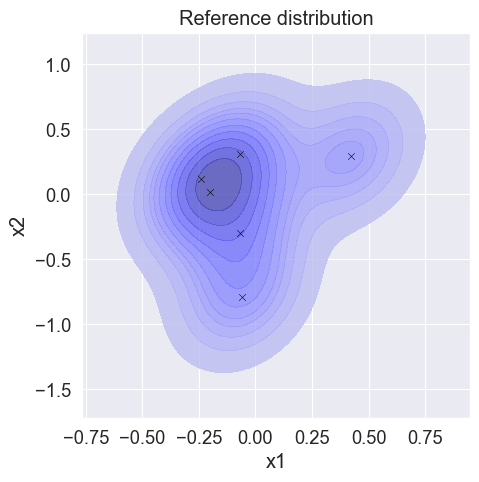

In [6]:
df_mu = pd.DataFrame(mu, columns=['x1', 'x2'])

plt.figure()
sns.set(context='paper', font_scale=1.5)
num_rows, num_cols = 1, 1
axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))[1]
plt.subplots_adjust(wspace=0.3, hspace=0.3)

title = f"{'Reference distribution'}"
sns.kdeplot(data=df_mu, x='x1', y='x2', fill=True, color='blue', levels=12, alpha=0.8, ax=axes, legend=False, thresh=0.05)
sns.scatterplot(data=df_mu, x='x1', y='x2', color='black', marker='x', ax=axes)
axes.set_title(title)
plt.savefig('Images/mudistribution.png', dpi=300, bbox_inches='tight',format="png")
plt.show()

### Four training distributions

<Figure size 640x480 with 0 Axes>

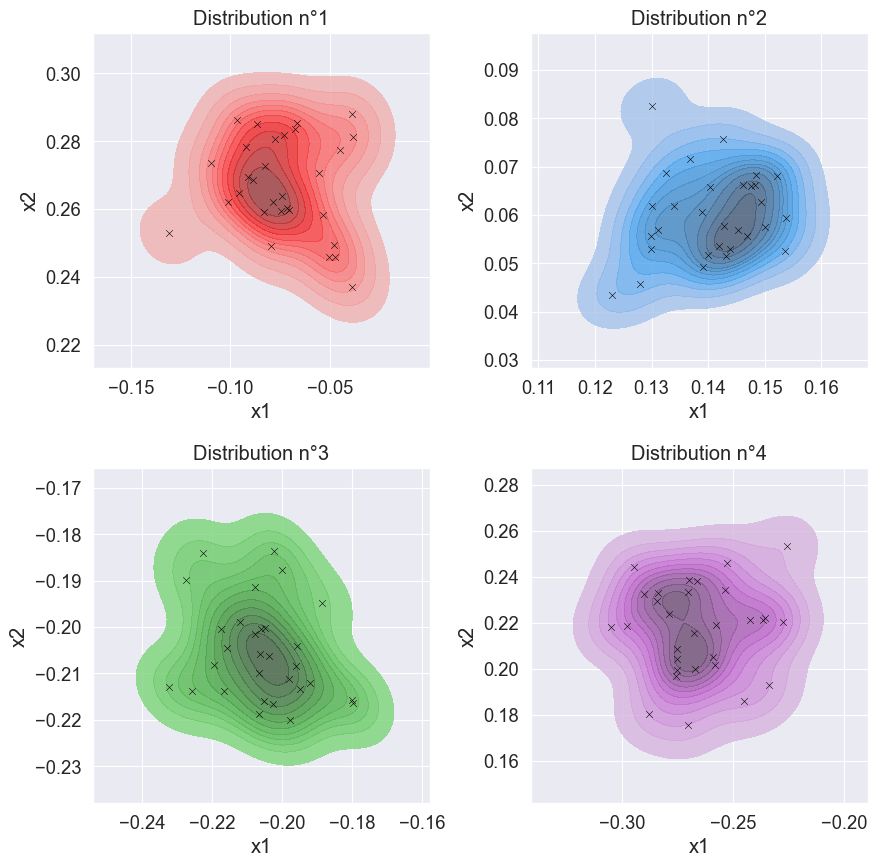

In [7]:
plt.figure()
# Number of distributions we want to see
distrib_to_plot = 5

# Plot parameters, style and subplots and colors
sns.set(context='paper', font_scale=1.5)
num_rows, num_cols = 2, 2
axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))[1].flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
palette = sns.color_palette('Set1', n_colors = distrib_to_plot)


# Initialize an empty list to hold dataframes
dfs = []

# Populate the list of DataFrames
for i, array in enumerate(distributions):
    distribution_number = i + 1

    # Create a new DataFrame for each distribution
    df = pd.DataFrame(array, columns=['x1', 'x2'])
    df['Distribution'] = distribution_number
    dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Plot each selected Gaussian sample with a different color
for i, (ax, color) in enumerate(zip(axes, palette)):
    df_i = result_df[result_df['Distribution'] == i+1]
    title = f"{'Distribution n°'}{i+1}"
    ax = sns.kdeplot(data=df_i, x='x1', y='x2', fill=True, color=color, levels=12, alpha=0.8, ax=ax, legend=False, thresh=0.05)
    ax = sns.scatterplot(data=df_i, x='x1', y='x2', color='black', marker='x', ax=ax)
    ax.set_title(title)

plt.savefig('Images/4distributions.png', dpi=300, bbox_inches='tight',format="png")
plt.show()

### Reference measure with the data

<Figure size 640x480 with 0 Axes>

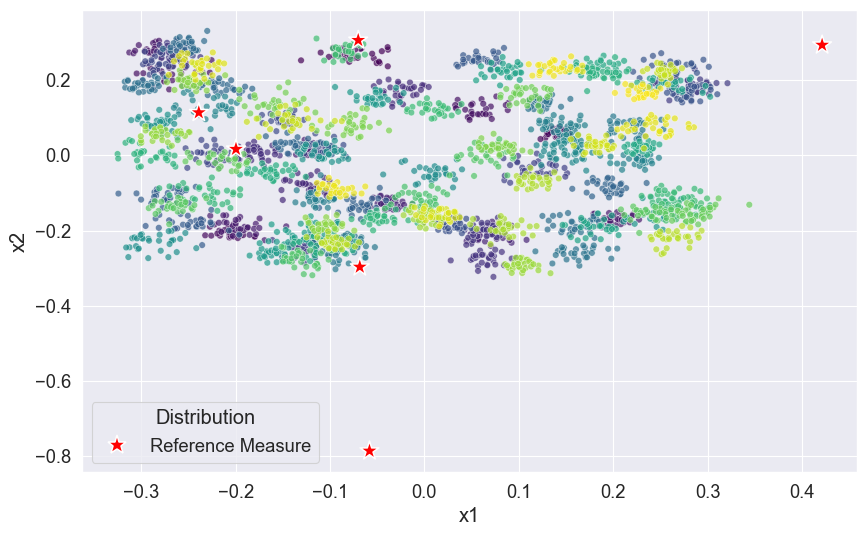

In [8]:
plt.figure()

sns.set(context='paper', font_scale=1.5)

# Reshape data for Seaborn
mu_df = pd.DataFrame(mu, columns=['x1', 'x2'])
mu_df['Distribution'] = 'Reference Measure'

distributions_df = pd.DataFrame(np.concatenate(distributions), columns=['x1', 'x2'])
distributions_df['Distribution'] = np.repeat(range(num_distributions), num_sample)


# Plot distributions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x1', y='x2', hue='Distribution',
                data=distributions_df, palette=sns.color_palette("viridis", num_distributions), alpha=0.7, legend=None)

# Overlay mu samples with crosses
sns.scatterplot(x='x1', y='x2', style='Distribution',
                markers=['*'], data=mu_df, color='red', s=200)

# Set labels and legend
plt.xlabel('x1')
plt.ylabel('x2')

plt.savefig('Images/alldistrib.png', dpi=300, bbox_inches='tight',format="png")
plt.show()

### True vs. Predicted values on test set

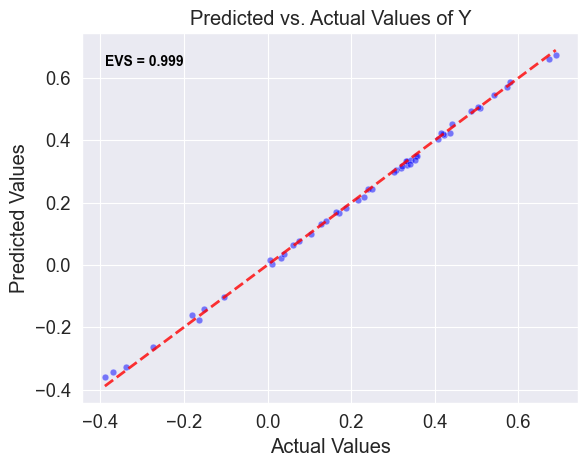

In [9]:
plt.figure()

sns.set(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test, y=predictions, color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, alpha = 0.8)
plt.text(min(y_test), max(predictions), f'EVS = {evs:.3f}', ha='left', va='top', color='black', fontsize=10, weight='bold')

plt.title('Predicted vs. Actual Values of Y')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.savefig('Images/regression_toy_experiment.png', dpi=300, bbox_inches='tight',format="png")
plt.show()

### Checking residuals

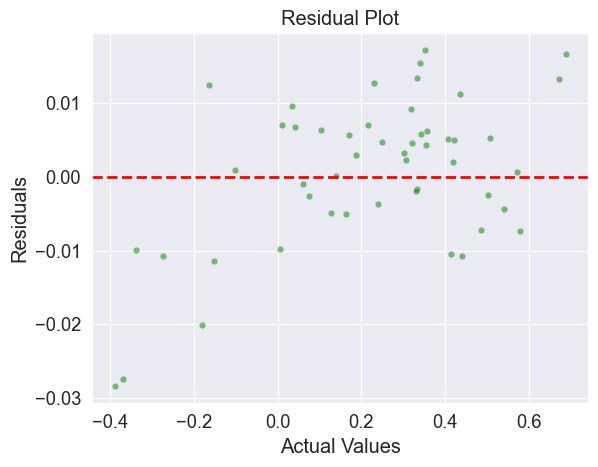

In [10]:
plt.figure()

residuals = y_test - predictions

sns.scatterplot(x=y_test, y=residuals, color='green', alpha=0.5)

plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')

plt.savefig('Images/residuals_toy_experiment.png', dpi=300, bbox_inches='tight',format="png")
plt.show()

#

# Evaluation of the impact of the OT regularisation coefficient $\varepsilon$

We use the same simulated data as previously.

In [11]:
## We choose our epsilon parameter and perform the sinkhirn algorithm and the krr
result_by_epsilon = []

for epsilon in np.arange(0, 50, 0.5):
    ## Performing optimak transport
    sinkhorn_solver_kwargs = {'epsilon': epsilon}
    sinkhorn_potentials = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, sinkhorn_solver_kwargs = sinkhorn_solver_kwargs)

    x_train, x_test, y_train, y_test = train_test_split(sinkhorn_potentials, y, test_size = 0.50, random_state = 42)

    ## We perform the Kernel Ridge Regression
    krr = KernelRidge(kernel = "rbf")

    ## Define the parameter grid
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1], 'gamma': [0.01, 0.1, 0.5, 1]}

    ## Create GridSearchCV object
    grid_search = GridSearchCV(estimator = krr, 
                            param_grid = param_grid, 
                            scoring = 'neg_mean_squared_error', 
                            cv = 5)

    ## Fit the model ie training the model
    grid_search.fit(X = x_train, y = y_train)

    ## Get the best parameters from the cross validation
    best_params = grid_search.best_params_

    ## Get the best model
    my_model = grid_search.best_estimator_


    ## Obtain predictions for the test set
    predictions = my_model.predict(X = x_test)

    ## Compute the MSE
    #mse = mean_squared_error(y_true = y_test, y_pred = predictions)

    # Compute the EVS
    evs = explained_variance_score(y_true = y_test, y_pred = predictions)

    ## Saving the result
    result_by_epsilon.append([epsilon, evs])

## Plotting the EVS against espilon

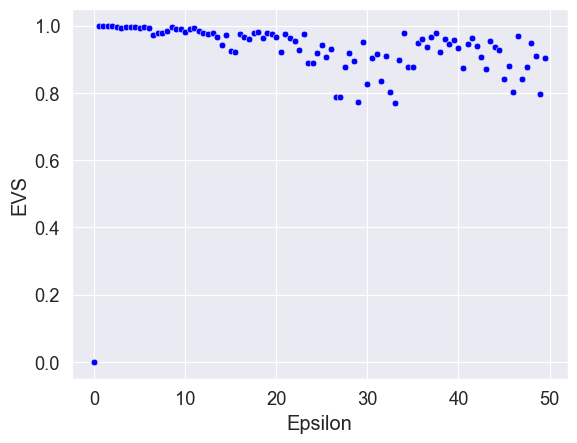

In [12]:
plt.figure()
# Extract x and y coordinates
x_coordinates = [coord[0] for coord in result_by_epsilon][0:200]
y_coordinates = [coord[1] for coord in result_by_epsilon][0:200]

# Set the Seaborn style
sns.set(context='paper', font_scale=1.5)

# Create a scatter plot with Seaborn
sns.scatterplot(x=x_coordinates, y=y_coordinates, marker='o', color = "blue")

# Set plot labels and title
plt.title('')
plt.xlabel('Epsilon')
plt.ylabel('EVS')

# Show the plot
plt.savefig('Images/evs_vs_epsilon.png', dpi=300, bbox_inches='tight',format="png")

plt.show()

# Evaluation of the impact of the dimension

Here we consider only a small set of dimensions: $2$, $3$, $4$, $6$ and $8$.

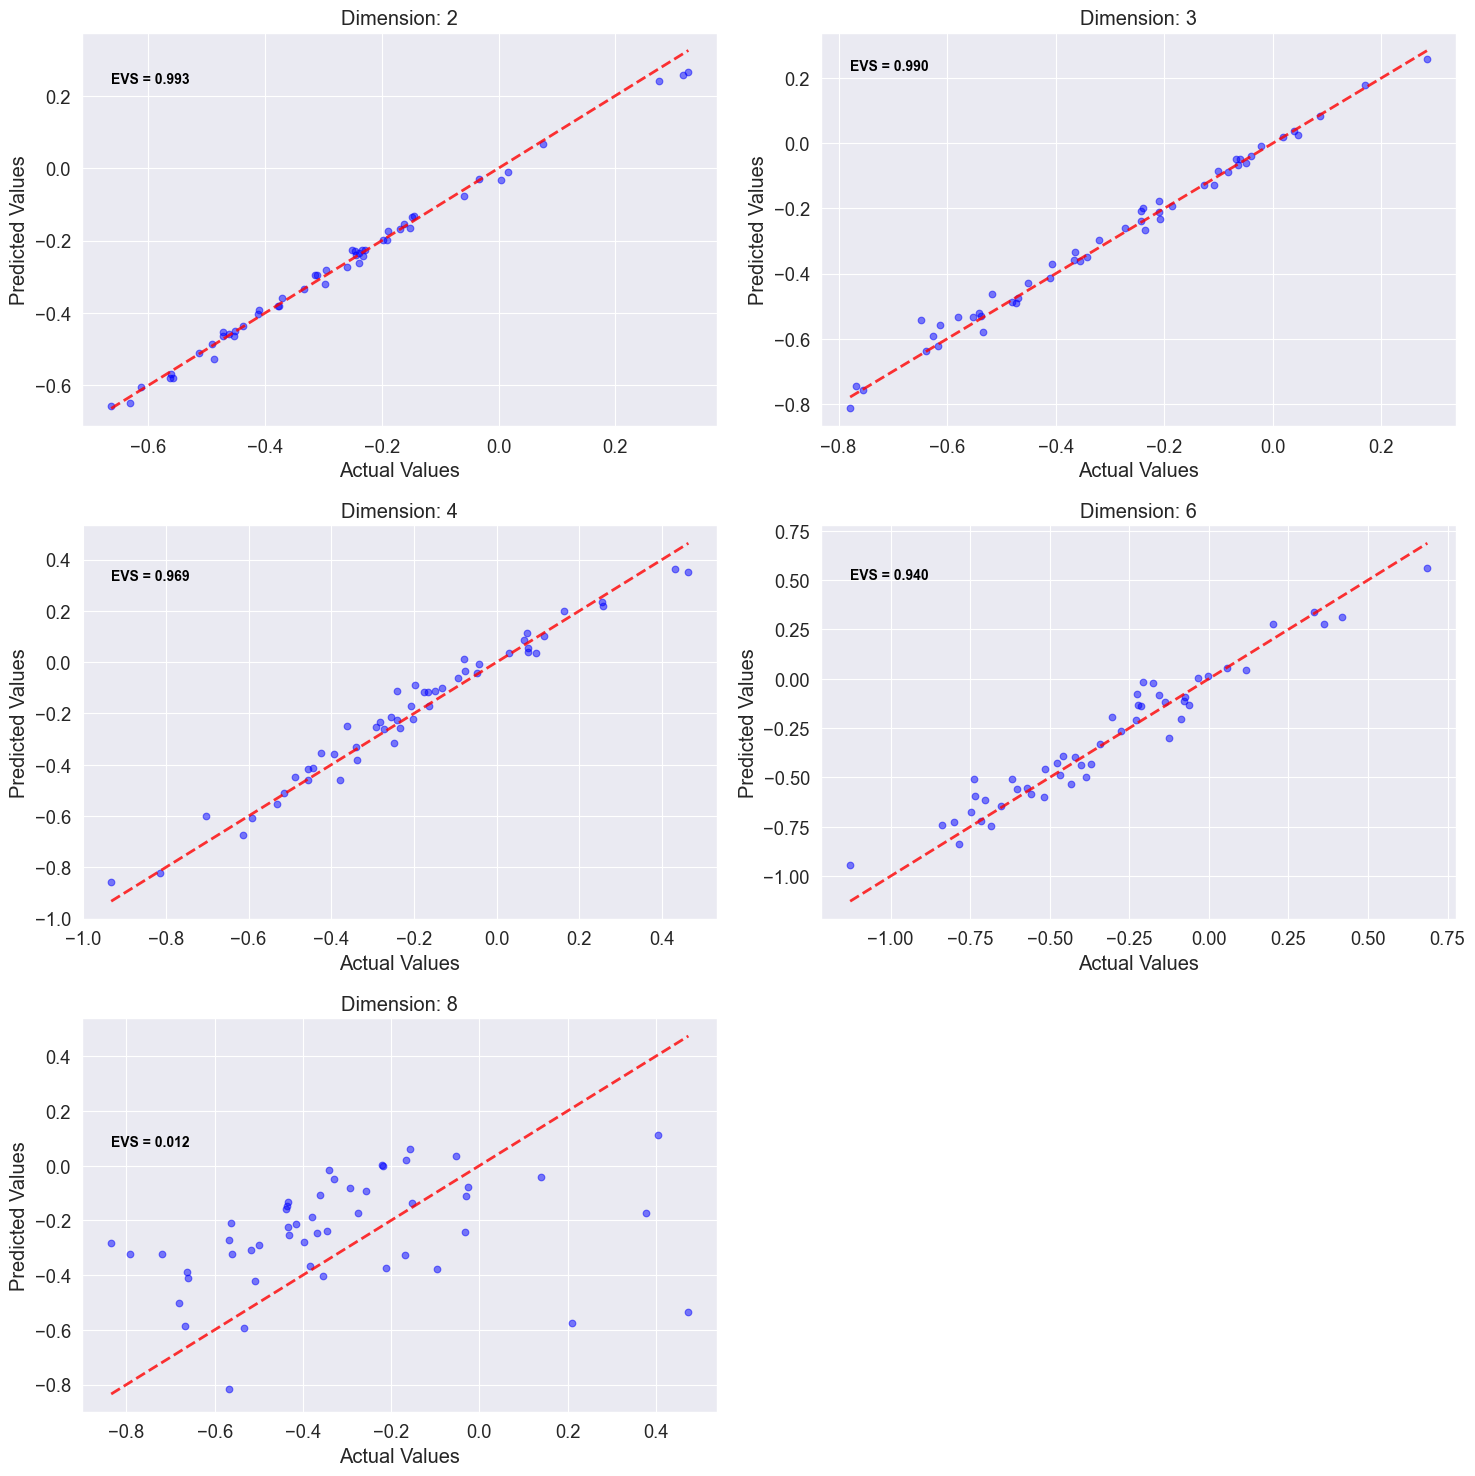

In [13]:
## Saving time and EVS
times = []
explained_variances = []

## Defining the dimensions
dimensions_considered = [2, 3, 4, 6, 8]

num_plots = len(dimensions_considered)

# Create a grid of subplots
num_rows = int(np.ceil(np.sqrt(num_plots)))
num_cols = int(np.ceil(num_plots / num_rows))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes if necessary
if num_plots == 1:
    axes = np.array([[axes]])

for i, dimension in enumerate(dimensions_considered):

    ## Initializing the figure and timer
    #plt.figure()
    start_time = time.time()

    # Number of distributions
    num_distributions = 100

    # Number of sample for each distribution
    num_sample = 30

    # Generate random means and variances
    means = np.random.uniform(low = -0.3, high = 0.3, size = (num_distributions, dimension))
    variances = np.random.uniform(low = 0.0001, high = 0.0004, size = num_distributions)

    # Generate random samples for each distribution which is the X
    distributions = [np.random.multivariate_normal(mean, np.eye(dimension) * variance, num_sample) for mean, variance in zip(means, variances)]

    # We compute the new Y. The formula is available in the Methodological Report.
    y = [np.sum((-1) ** (np.arange(len(mean)) + 1) * (mean + 0.5) ** (np.arange(len(mean)) + 1))/1+np.sqrt(variance) for mean, variance in zip(means, variances)]

    ## Sampling the mu measure
    mu_num_sample = 6
    mu_mean = [0] * dimension
    mu_variance = 0.1

    mu = np.random.multivariate_normal(mu_mean, np.eye(dimension) * mu_variance, mu_num_sample)

    ## Convert the list of points mu into a WeightedPointCloud object
    mu_cloud = WeightedPointCloud(
        cloud=jnp.array(mu),
        weights=jnp.ones(mu_num_sample)
    )

    ## First we convert the list all the sampled distributions to WeightedPointCloud objects
    list_of_weighted_point_clouds = []
    for sample in distributions:
        distrib_cloud = WeightedPointCloud(
            cloud=jnp.array(sample),
            weights=jnp.ones(len(sample))
        )
        list_of_weighted_point_clouds.append(distrib_cloud)

    ## We need to convert the cloud list to a VectorizedWeightedPointCloud
    x_cloud = pad_point_clouds(list_of_weighted_point_clouds)

    ## We choose our epsilon parameter and perform the sinkhirn algorithm
    sinkhorn_solver_kwargs = {'epsilon': 0.01}
    sinkhorn_potentials = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, sinkhorn_solver_kwargs = sinkhorn_solver_kwargs)

    ## Splitting train and test sample.
    x_train, x_test, y_train, y_test = train_test_split(sinkhorn_potentials, y, test_size = 0.50, random_state = 42)

    ## We perform the Kernel Ridge Regression
    krr = KernelRidge(kernel = "rbf")

    ## Define the parameter grid
    param_grid = {'alpha': [0.01, 0.1, 0.5, 1], 'gamma': [0.01, 0.1, 0.5, 1]}

    ## Create GridSearchCV object
    grid_search = GridSearchCV(estimator = krr, 
                            param_grid = param_grid, 
                            scoring = 'neg_mean_squared_error', 
                            cv = 5)

    ## Fit the model ie training the model
    grid_search.fit(X = x_train, y = y_train)

    ## Get the best parameters from the cross validation
    best_params = grid_search.best_params_
    #print("Best Parameters:", best_params)

    ## Get the best model
    my_model = grid_search.best_estimator_


    ## Obtain predictions for the test set
    predictions = my_model.predict(X = x_test)

    ## Compute the MSE
    #mse = mean_squared_error(y_true = y_test, y_pred = predictions)

    # Compute the EVS
    evs = explained_variance_score(y_true = y_test, y_pred = predictions)


    # Plotting
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].scatter(y_test, predictions, color='blue', alpha=0.5)
    axes[row_idx, col_idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, alpha=0.8)
    axes[row_idx, col_idx].text(min(y_test), max(predictions), f'EVS = {evs:.3f}', ha='left', va='top', color='black', fontsize=10, weight='bold')
    axes[row_idx, col_idx].set_title(f'Dimension: {dimension}')
    axes[row_idx, col_idx].set_xlabel('Actual Values')
    axes[row_idx, col_idx].set_ylabel('Predicted Values')

    ## Stopping the timer and saving time and evs score
    end_time = time.time()
    iteration_time = end_time - start_time
    
    times.append(iteration_time)
    explained_variances.append(evs)

# Hide empty subplots if num_plots is not a perfect square
for i in range(len(dimensions_considered), num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].axis('off')


plt.tight_layout()
plt.savefig("Images/regression_for_every_dimensions.png", dpi=300, bbox_inches='tight', format="png")
plt.show()

## Plotting EVS and Time against dimension

Note that the time needed for each computation changes every time. For correct comparaison we should compute multiple times the ROT and KRR for a single dimension and use boxplots to compare the time needed.

<Figure size 640x480 with 0 Axes>

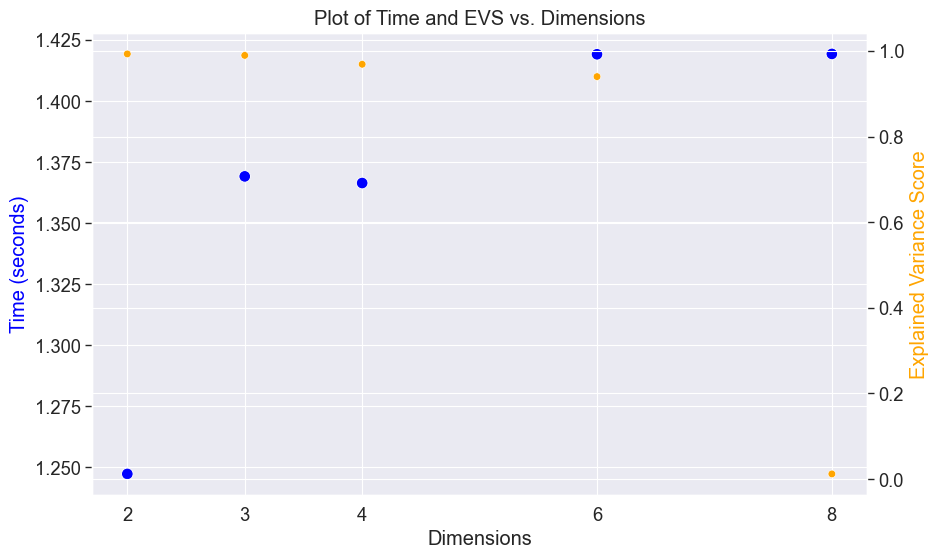

In [14]:
plt.figure()

## Create DataFrames for Seaborn
df_times = pd.DataFrame({'Dimensions': dimensions_considered, 'Values': times, 'Metric': 'Time'})
df_variances = pd.DataFrame({'Dimensions': dimensions_considered, 'Values': explained_variances, 'Metric': 'Explained Variance'})

## Set Seaborn style
sns.set(context='paper', font_scale=1.5)

## Create the scatter plot for Time
plt.figure(figsize=(10, 6))
ax1 = sns.scatterplot(x='Dimensions', y='Values', hue='Metric', markers=['o'], data=df_times, palette={'Time': 'blue'}, s= 70, legend = None)

## Create the secondary y-axis for Explained Variance
ax2 = ax1.twinx()
sns.scatterplot(x='Dimensions', y='Values', hue='Metric', markers=['o'], data=df_variances, palette={'Explained Variance': 'orange'}, s = 30, ax=ax2, legend = None)

## x Axis
ax1.set_xticks(dimensions_considered)

## Add labels, legend, and title
plt.xlabel('Dimensions')
ax1.set_ylabel('Time (seconds)', color='blue')
ax2.set_ylabel('Explained Variance Score', color='orange')
plt.title('Plot of Time and EVS vs. Dimensions')

plt.savefig("Images/comparaison_dimensions.png", dpi=300, bbox_inches='tight',format="png")

plt.show()

# Evaluation of the impact of the reference measure

We study three different reference measure:
- $\mathcal{N}(0, 0.1)$
- $\mathcal{U}([-20,10])$
- $\mathcal{N}(-0.2, 0.0001)$

## Generating new dataset

In [15]:
# Set the seed for reproducibility
np.random.seed(42)

# Number of distributions
num_distributions = 100
# Number of sample for each distribution
num_sample = 30

# Generate random means and variances
means = np.random.uniform(low = -0.3, high = 0.3, size = (num_distributions, 2))
variances = np.random.uniform(low = 0.0001, high = 0.0004, size = num_distributions)
# Generate random samples for each distribution which is the X
distributions = [np.random.multivariate_normal(mean, np.eye(2) * variance, num_sample) for mean, variance in zip(means, variances)]

# Lets compute the Ys according to the paper
y = [(mean[0]+0.5-(mean[1]+0.5)**2)/1+np.sqrt(variance) for mean, variance in zip(means, variances)]

mu_num_sample = 6
## Next we select the reference measure, we propose three possibilities below

## Sampling & plotting the $\mu$ measure - Gaussian(0, 0.1)

In [16]:
## Sampling the mu measure - Gaussian(0, 0.1)
mu1_mean = [0, 0]
mu1_variance = 0.1
mu1 = np.random.multivariate_normal(mu1_mean, np.eye(2) * mu1_variance, mu_num_sample)

<Figure size 640x480 with 0 Axes>

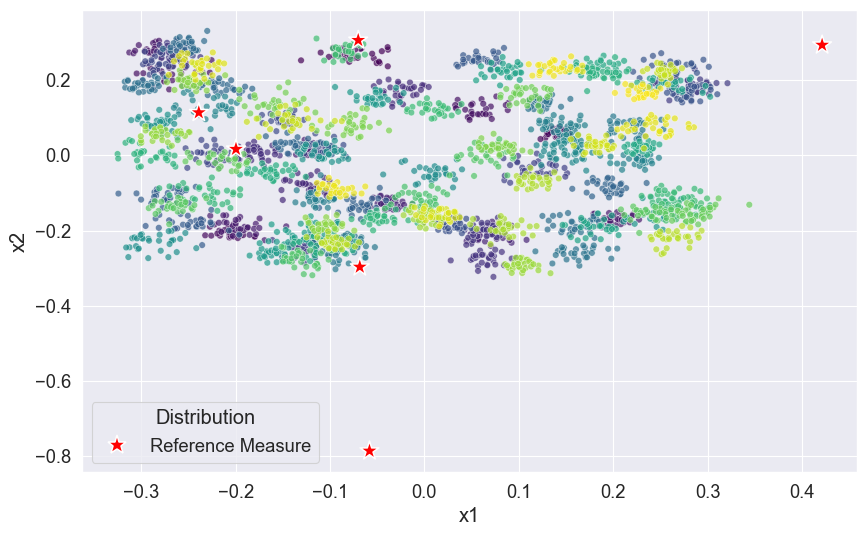

In [17]:
plt.figure()
sns.set(context='paper', font_scale=1.5)

## Reshape data for Seaborn
mu_df = pd.DataFrame(mu1, columns=['x1', 'x2'])
mu_df['Distribution'] = 'Reference Measure'

distributions_df = pd.DataFrame(np.concatenate(distributions), columns=['x1', 'x2'])
distributions_df['Distribution'] = np.repeat(range(num_distributions), num_sample)

## Plot distributions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x1', y='x2', hue='Distribution',
                data=distributions_df, palette=sns.color_palette("viridis", num_distributions), alpha=0.7, legend=None)

## Overlay mu samples with crosses
sns.scatterplot(x='x1', y='x2', style='Distribution',
                markers=['*'], data=mu_df, color='red', s=200)

# Set labels and legend
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()

## Sampling & plotting the $\mu$ measure - Uniform([-20, -10])

In [18]:
## Sampling the mu measure - Uniform([-20, -10])
lower_limit_x, upper_limit_x = -20, -10
lower_limit_y, upper_limit_y = -20, -10
mu2 = np.random.uniform(low=[lower_limit_x, lower_limit_y], high=[upper_limit_x, upper_limit_y], size=(mu_num_sample, 2))

<Figure size 640x480 with 0 Axes>

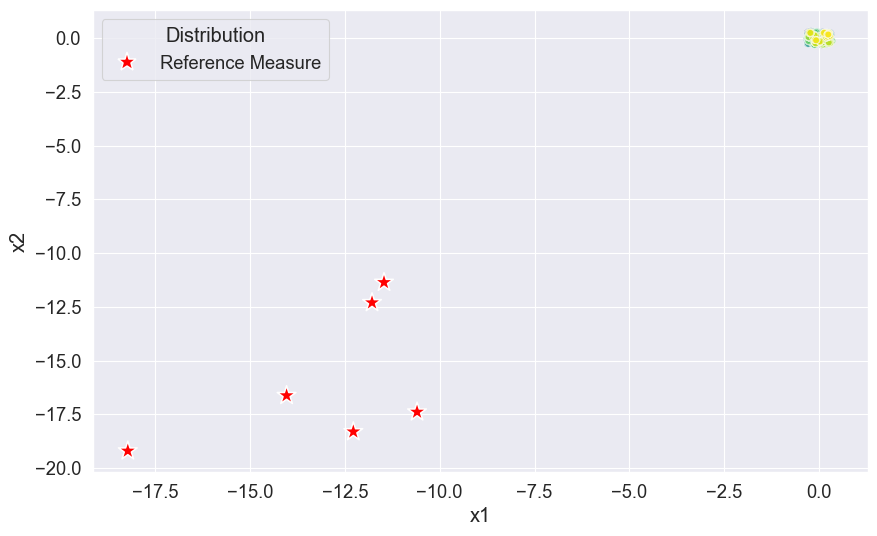

In [19]:
plt.figure()
sns.set(context='paper', font_scale=1.5)

## Reshape data for Seaborn
mu_df = pd.DataFrame(mu2, columns=['x1', 'x2'])
mu_df['Distribution'] = 'Reference Measure'

distributions_df = pd.DataFrame(np.concatenate(distributions), columns=['x1', 'x2'])
distributions_df['Distribution'] = np.repeat(range(num_distributions), num_sample)

## Plot distributions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x1', y='x2', hue='Distribution',
                data=distributions_df, palette=sns.color_palette("viridis", num_distributions), alpha=0.7, legend=None)

## Overlay mu samples with crosses
sns.scatterplot(x='x1', y='x2', style='Distribution',
                markers=['*'], data=mu_df, color='red', s=200)

# Set labels and legend
plt.xlabel('x1')
plt.ylabel('x2')

plt.savefig('Images/RefMeasure_uniform.png', dpi=300, bbox_inches='tight',format="png")

plt.show()

## Sampling and plotting the $\mu$ measure - Gaussian(-0.2, 0.0001)

In [20]:
## Sampling the mu measure - Gaussian(-0.2, 0.0001)
mu3_mean = [-0.2, -0.2]
mu3_variance = 0.0001
mu3 = np.random.multivariate_normal(mu3_mean, np.eye(2) * mu3_variance, mu_num_sample)

<Figure size 640x480 with 0 Axes>

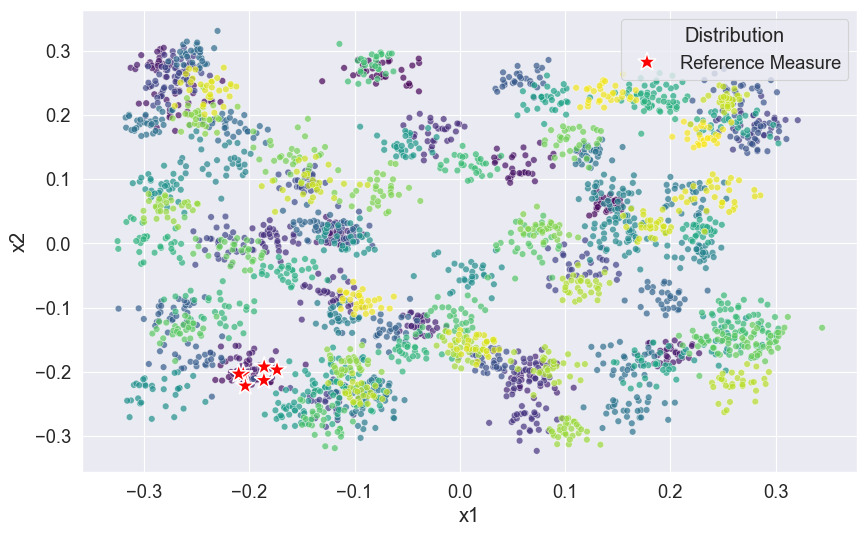

In [21]:
plt.figure()
sns.set(context='paper', font_scale=1.5)


## Reshape data for Seaborn
mu_df = pd.DataFrame(mu3, columns=['x1', 'x2'])
mu_df['Distribution'] = 'Reference Measure'

distributions_df = pd.DataFrame(np.concatenate(distributions), columns=['x1', 'x2'])
distributions_df['Distribution'] = np.repeat(range(num_distributions), num_sample)

## Plot distributions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x1', y='x2', hue='Distribution',
                data=distributions_df, palette=sns.color_palette("viridis", num_distributions), alpha=0.7, legend=None)

## Overlay mu samples with crosses
sns.scatterplot(x='x1', y='x2', style='Distribution',
                markers=['*'], data=mu_df, color='red', s=200)

# Set labels and legend
plt.xlabel('x1')
plt.ylabel('x2')

plt.savefig('Images/RefMeasure_specific.png', dpi=300, bbox_inches='tight',format="png")

plt.show()

## Performing ROT and KRR with the selected $\mu$ measure

Best Parameters: {'alpha': 0.01, 'gamma': 1}
Explained Variance Score on the Test Set: 0.46705657143623003


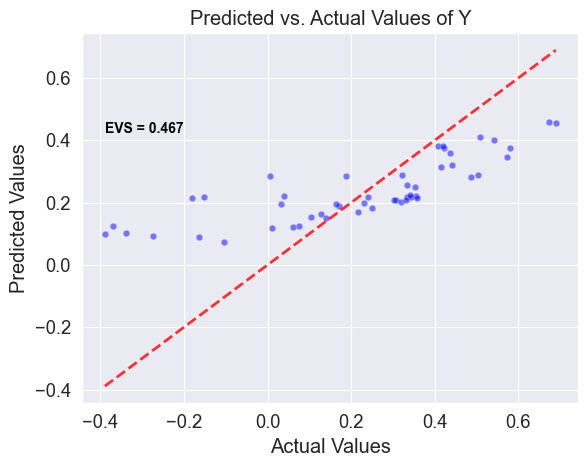

In [22]:
### Must select the mu measure
mu = mu3 # or mu2 or mu3

## Convert the list of points mu into a WeightedPointCloud object
mu_cloud = WeightedPointCloud(
    cloud=jnp.array(mu),
    weights=jnp.ones(mu_num_sample)
)


## First we convert the list all the sampled distributions to WeightedPointCloud objects
list_of_weighted_point_clouds = []
for sample in distributions:
    distrib_cloud = WeightedPointCloud(
        cloud=jnp.array(sample),
        weights=jnp.ones(len(sample))
    )
    list_of_weighted_point_clouds.append(distrib_cloud)

## We need to convert the cloud list to a VectorizedWeightedPointCloud
x_cloud = pad_point_clouds(list_of_weighted_point_clouds)

## We choose our epsilon parameter and perform the sinkhirn algorithm
sinkhorn_solver_kwargs = {'epsilon': 0.01}
sinkhorn_potentials = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, sinkhorn_solver_kwargs = sinkhorn_solver_kwargs)

## Splitting the data into train and test 
x_train, x_test, y_train, y_test = train_test_split(sinkhorn_potentials, y, test_size = 0.50, random_state = 42)


## We perform the Kernel Ridge Regression
krr = KernelRidge(kernel = "rbf")

## Define the parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1], 'gamma': [0.01, 0.1, 0.5, 1]}

## Create GridSearchCV object
grid_search = GridSearchCV(estimator = krr, 
                        param_grid = param_grid, 
                        scoring = 'neg_mean_squared_error', 
                        cv = 5)

## Fit the model ie training the model
grid_search.fit(X = x_train, y = y_train)

## Get the best parameters from the cross validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

## Get the best model
my_model = grid_search.best_estimator_


## Obtain predictions for the test set
predictions = my_model.predict(X = x_test)

## Compute the MSE
#mse = mean_squared_error(y_true = y_test, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test, y_pred = predictions)

# Print the MSE and EVS
#print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

plt.figure()

sns.set(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test, y=predictions, color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, alpha = 0.8)
plt.text(min(y_test), max(predictions), f'EVS = {evs:.3f}', ha='left', va='top', color='black', fontsize=10, weight='bold')

plt.title('Predicted vs. Actual Values of Y')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.savefig('Images/regression_with_specific_refMeasure.png', dpi=300, bbox_inches='tight',format="png")

plt.show()

# Changing the simulated data's variance

The new simulated data is taken from the distribution $\mathcal{N}(\mu, \sigma I_{2})$, with $\mu \sim \mathcal{U}([-0.3, 0.3])$ and $\sigma \sim \mathcal{U}([0.1, 2])$

In [23]:
# Number of distributions
num_distributions = 100
# Number of sample for each distribution
num_sample = 30


# Generate random means and variances
means = np.random.uniform(low = -0.3, high = 0.3, size = (num_distributions, 2))
variances = np.random.uniform(low = 0.1, high = 2, size = num_distributions)
# Generate random samples for each distribution which is the X
distributions = [np.random.multivariate_normal(mean, np.eye(2) * variance, num_sample) for mean, variance in zip(means, variances)]

# Lets compute the Ys according to the paper
y = [(mean[0]+0.5-(mean[1]+0.5)**2)/1+np.sqrt(variance) for mean, variance in zip(means, variances)]


## Sampling the mu measure
mu_num_sample = 6
mu_mean = [0, 0]
mu_variance = 0.1
mu = np.random.multivariate_normal(mu_mean, np.eye(2) * mu_variance, mu_num_sample)


## Convert the list of points mu into a WeightedPointCloud object
mu_cloud = WeightedPointCloud(
    cloud=jnp.array(mu),
    weights=jnp.ones(mu_num_sample)
)

## First we convert the list all the sampled distributions to WeightedPointCloud objects
list_of_weighted_point_clouds = []
for sample in distributions:
    distrib_cloud = WeightedPointCloud(
        cloud=jnp.array(sample),
        weights=jnp.ones(len(sample))
    )
    list_of_weighted_point_clouds.append(distrib_cloud)

## We need to convert the cloud list to a VectorizedWeightedPointCloud
x_cloud = pad_point_clouds(list_of_weighted_point_clouds)

## We choose our epsilon parameter and perform the sinkhirn algorithm
sinkhorn_solver_kwargs = {'epsilon': 0.01}
sinkhorn_potentials = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, sinkhorn_solver_kwargs = sinkhorn_solver_kwargs)


## Splitting the data into train and test 
x_train, x_test, y_train, y_test = train_test_split(sinkhorn_potentials, y, test_size = 0.50, random_state = 42)


## We perform the Kernel Ridge Regression
krr = KernelRidge(kernel = "rbf")

## Define the parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 10], 'gamma': [0.01, 0.1, 0.5, 1, 10]}

## Create GridSearchCV object
grid_search = GridSearchCV(estimator = krr, 
                        param_grid = param_grid, 
                        scoring = 'neg_mean_squared_error', 
                        cv = 5)

## Fit the model ie training the model
grid_search.fit(X = x_train, y = y_train)

## Get the best parameters from the cross validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

## Get the best model
my_model = grid_search.best_estimator_


## Obtain predictions for the test set
predictions = my_model.predict(X = x_test)

## Compute the MSE
#mse = mean_squared_error(y_true = y_test, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test, y_pred = predictions)

# Print the MSE and EVS
#print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

Best Parameters: {'alpha': 0.01, 'gamma': 0.1}
Explained Variance Score on the Test Set: 0.5572001090442742


## Plotting the reference measure and the data

<Figure size 640x480 with 0 Axes>

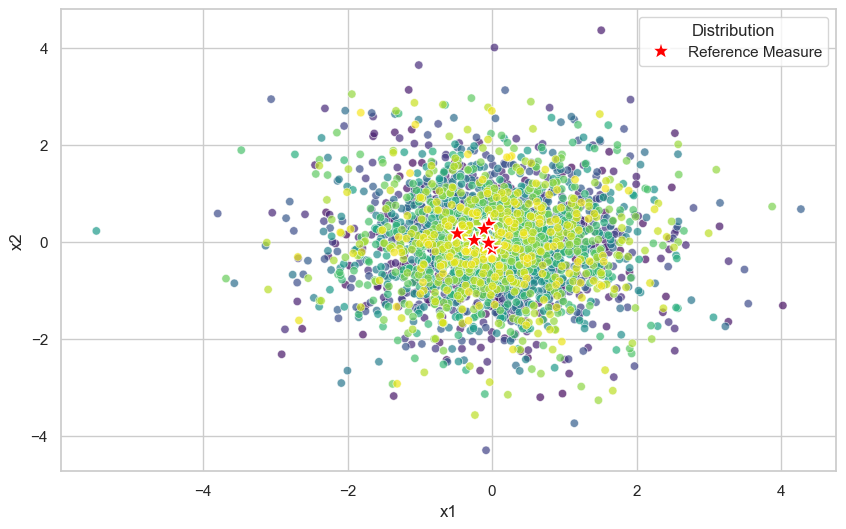

In [24]:
plt.figure()

sns.set(context='paper', font_scale=1.5)

# Reshape data for Seaborn
mu_df = pd.DataFrame(mu, columns=['x1', 'x2'])
mu_df['Distribution'] = 'Reference Measure'

distributions_df = pd.DataFrame(np.concatenate(distributions), columns=['x1', 'x2'])
distributions_df['Distribution'] = np.repeat(range(num_distributions), num_sample)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot distributions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x1', y='x2', hue='Distribution',
                data=distributions_df, palette=sns.color_palette("viridis", num_distributions), alpha=0.7, legend=None)

# Overlay mu samples with crosses
sns.scatterplot(x='x1', y='x2', style='Distribution',
                markers=['*'], data=mu_df, color='red', s=200)

# Set labels and legend
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()

# Changing the simulated data's mean

The new simulated data is taken from the distribution $\mathcal{N}(\mu, \sigma I_{2})$, with $\mu \sim \mathcal{U}([-5, 5])$ and $\sigma \sim \mathcal{U}([0.0001, 0.0004])$

In [25]:
# Number of distributions
num_distributions = 100
# Number of sample for each distribution
num_sample = 30


# Generate random means and variances
means = np.random.uniform(low = -5, high = 5, size = (num_distributions, 2))
variances = np.random.uniform(low = 0.0001, high = 0.0004, size = num_distributions)
# Generate random samples for each distribution which is the X
distributions = [np.random.multivariate_normal(mean, np.eye(2) * variance, num_sample) for mean, variance in zip(means, variances)]

# Lets compute the Ys according to the paper
y = [(mean[0]+0.5-(mean[1]+0.5)**2)/1+np.sqrt(variance) for mean, variance in zip(means, variances)]


## Sampling the mu measure
mu_num_sample = 6
mu_mean = [0, 0]
mu_variance = 0.1
mu = np.random.multivariate_normal(mu_mean, np.eye(2) * mu_variance, mu_num_sample)


## Convert the list of points mu into a WeightedPointCloud object
mu_cloud = WeightedPointCloud(
    cloud=jnp.array(mu),
    weights=jnp.ones(mu_num_sample)
)

## First we convert the list all the sampled distributions to WeightedPointCloud objects
list_of_weighted_point_clouds = []
for sample in distributions:
    distrib_cloud = WeightedPointCloud(
        cloud=jnp.array(sample),
        weights=jnp.ones(len(sample))
    )
    list_of_weighted_point_clouds.append(distrib_cloud)

## We need to convert the cloud list to a VectorizedWeightedPointCloud
x_cloud = pad_point_clouds(list_of_weighted_point_clouds)

## We choose our epsilon parameter and perform the sinkhirn algorithm
sinkhorn_solver_kwargs = {'epsilon': 0.01}
sinkhorn_potentials = clouds_to_dual_sinkhorn(points = x_cloud, mu = mu_cloud, sinkhorn_solver_kwargs = sinkhorn_solver_kwargs)


## Splitting the data into train and test 
x_train, x_test, y_train, y_test = train_test_split(sinkhorn_potentials, y, test_size = 0.50, random_state = 42)


## We perform the Kernel Ridge Regression
krr = KernelRidge(kernel = "rbf")

## Define the parameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1, 10], 'gamma': [0.01, 0.1, 0.5, 1, 10]}

## Create GridSearchCV object
grid_search = GridSearchCV(estimator = krr, 
                        param_grid = param_grid, 
                        scoring = 'neg_mean_squared_error', 
                        cv = 5)

## Fit the model ie training the model
grid_search.fit(X = x_train, y = y_train)

## Get the best parameters from the cross validation
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

## Get the best model
my_model = grid_search.best_estimator_


## Obtain predictions for the test set
predictions = my_model.predict(X = x_test)

## Compute the MSE
#mse = mean_squared_error(y_true = y_test, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test, y_pred = predictions)

# Print the MSE and EVS
#print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

Best Parameters: {'alpha': 0.01, 'gamma': 0.01}
Explained Variance Score on the Test Set: 0.6685869581123176


## Plotting the reference measure and the data

<Figure size 640x480 with 0 Axes>

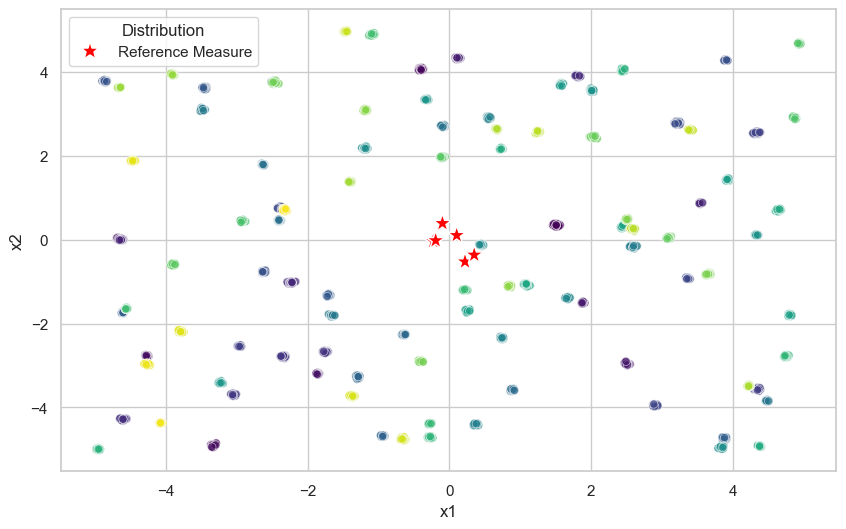

In [26]:
plt.figure()

sns.set(context='paper', font_scale=1.5)

# Reshape data for Seaborn
mu_df = pd.DataFrame(mu, columns=['x1', 'x2'])
mu_df['Distribution'] = 'Reference Measure'

distributions_df = pd.DataFrame(np.concatenate(distributions), columns=['x1', 'x2'])
distributions_df['Distribution'] = np.repeat(range(num_distributions), num_sample)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot distributions
plt.figure(figsize=(10, 6))
sns.scatterplot(x='x1', y='x2', hue='Distribution',
                data=distributions_df, palette=sns.color_palette("viridis", num_distributions), alpha=0.7, legend=None)

# Overlay mu samples with crosses
sns.scatterplot(x='x1', y='x2', style='Distribution',
                markers=['*'], data=mu_df, color='red', s=200)

# Set labels and legend
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()